# `Hands-on: Build a Knowledge Navigator Agent Using Gemini, Tools & RAG`

Before we build the agent, let us understand the RAG workflow


`LLMs rely heavily on their pretraining data.` When they lack the relevant content or domain-specific knowledge needed to answer a query, they default to producing responses that are probabilistically plausible—but not necessarily factual. In other words: hallucinations.

`For knowledge-centric use cases, this is a serious limitation.` `Accurate` outputs `require current, domain-specific information`, and those outputs must be grounded in a verifiable knowledge base to maintain `auditability and transparency`.

Since LLMs cannot access your internal documents by default, we have the RAG `(Retrieval-Augmented Generation) framework - bridges the gap` by retrieving the right information from your own trusted sources and allowing the model to generate answers built directly on that foundation.


`Retrieval-Augmented Generation (RAG) is an AI framework that enhances the capabilities of large language models (LLMs) by incorporating external knowledge sources.`

`RAG works by retrieving relevant information from a knowledge base and using it to augment the LLM’s input, allowing the model to generate more accurate, up-to-date, and contextually relevant responses.`


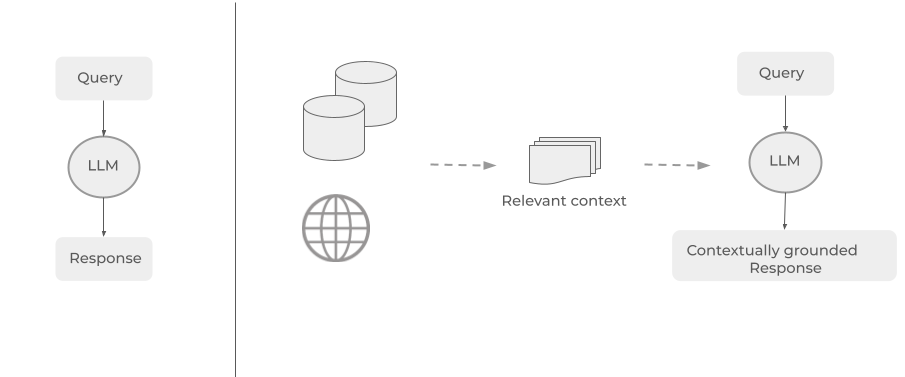

## A typical RAG pipeline
<!-- 1. Document ingestion
2. Chunking
3. Embedding
4. Vector storage
5. Query embedding
6. Similarity search
7. Prompt construction
8. LLM generation
9. Answer (with citations) -->

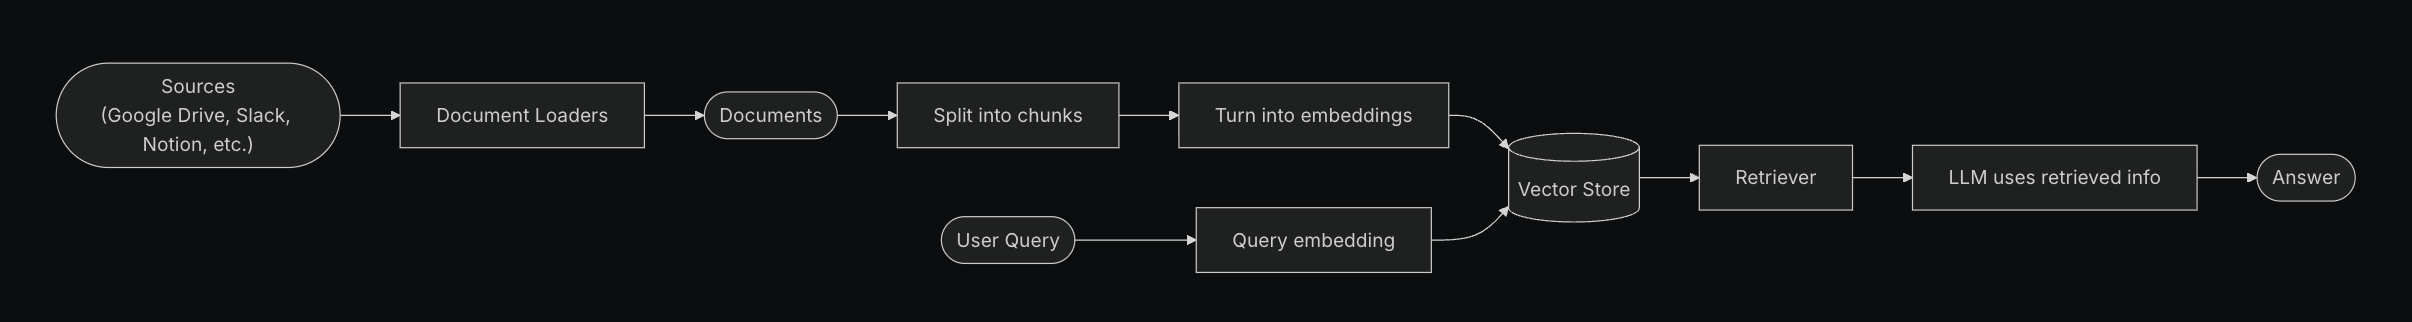


## Key Components of a RAG System

1. Document loader (PDF, text, HTML, etc.)
2. Chunker (sliding window / token-based)
3. Embedding model
4. Vector store (ChromaDB, Pinecone, FAISS, etc.)
5. Retriever
6. Prompt template
7. Generator LLM (local or API)

We will define the pipeline and implement each component step by step

### 1. Document Ingestion
- First upload your documents to create your own knowledgebase


In [ ]:
import os
import shutil
from google.colab import files

In [ ]:

# Create a directory to store uploaded PDFs
pdf_dir = "/content/pdfs"
if os.path.exists(pdf_dir):
    shutil.rmtree(pdf_dir) # Remove existing directory if necessary
os.makedirs(pdf_dir, exist_ok=True)
print(f"Created directory: {pdf_dir}")

# Upload the PDFs from your local machine
print("Please upload your PDF files now:")
uploaded = files.upload()

# Move the uploaded files into the created directory
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(pdf_dir, filename))
    print(f"Moved '{filename}' to '{pdf_dir}/'")

print("\nUpload complete.")

Created directory: /content/pdfs
Please upload your PDF files now:


Saving Localised rectal cancer.pdf to Localised rectal cancer.pdf
Moved 'Localised rectal cancer.pdf' to '/content/pdfs/'

Upload complete.


Wish to upload more files ?

In [ ]:

print("Please upload your PDF files now:")
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(pdf_dir, filename))
    print(f"Moved '{filename}' to '{pdf_dir}/'")

print("\nUpload complete.")

Please upload your PDF files now:



Upload complete.


- Next we need a document loader

In [ ]:
# Install langchain-community
!pip install langchain-community
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.37.0 requires opentelemetry-exporter-otlp-proto-common==1.37.0, but you have opentelemetry-exporter-otlp-proto-common 1.39.0 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.37.0 requires openteleme

In [ ]:


# Relevant imports - pdfloader
from langchain_community.document_loaders import PyPDFDirectoryLoader

# Load documents from the 'pdfs' directory
loader = PyPDFDirectoryLoader(pdf_dir)
documents = loader.load()

### 2. Chunking

Overcoming Token Limits: Most LLMs and embedding models have a maximum "context window" or token limit (e.g., 512 tokens for some models). Large documents often exceed these limits. Chunking breaks them into manageable pieces that fit within the model's constraints, preventing data truncation and loss of information.
1. Improving Retrieval Accuracy and Relevance (RAG): In RAG systems, the goal is to retrieve the most relevant information from a knowledge base to answer a user's query.
2. Large chunks can contain multiple topics, diluting the focus of their vector representation and making it harder to find specific, relevant information.
Smaller, focused chunks result in more precise embeddings that better represent a single idea or topic, leading to more accurate search results.

Types:
1. Fixed-size (words/tokens)
2. Semantic chunking
3. Document-Based / Structure-Aware Chunking:

Tips: 200–500 tokens/chunk, 10–20% overlap


In [ ]:
# Installing dependencies and bringing some relevant imports
!pip install -U langchain-text-splitters
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(documents)
print(f"Loaded {len(documents)} documents and split into {len(splits)} chunks.")

Loaded 18 documents and split into 217 chunks.


In [ ]:
# Let us see how each split looks like
print(splits[0])

page_content='SPECIAL ARTICLE
Localised rectal cancer: ESMO Clinical Practice Guideline for diagnosis,
treatment and follow-up5
R.-D. Hofheinz1, E. Fokas2, L. Benhaim3, T. J. Price4, D. Arnold5, R. Beets-Tan6, M. G. Guren7, G. A. P. Hospers8, S. Lonardi9,
I. D. Nagtegaal10,R .O .P e r e z11, A. Cervantes12,13 & E. Martinelli14, on behalf of the ESMO Guidelines Committee/C3' metadata={'producer': 'Acrobat Distiller 8.1.0 (Windows)', 'creator': 'Elsevier', 'creationdate': '2025-08-11T11:30:12+05:30', 'crossmarkdomains[2]': 'elsevier.com', 'crossmarkmajorversiondate': '2010-04-23', 'subject': 'Annals of Oncology, 36 (2025) 1007-1024. doi:10.1016/j.annonc.2025.05.528', 'author': 'R.-D. Hofheinz', 'elsevierwebpdfspecifications': '7.0.1', 'crossmarkdomainexclusive': 'true', 'robots': 'noindex', 'moddate': '2025-08-11T11:32:02+05:30', 'doi': '10.1016/j.annonc.2025.05.528', 'crossmarkdomains[1]': 'sciencedirect.com', 'title': 'Localised rectal cancer: ESMO Clinical Practice Guideline for diagn

### 3. Embedding: The Backbone of Retrieval

- Convert text → numerical vectors

- Similarity = cosine or dot product

- Good embedding models: all-MiniLM-L6-v2 (fast), OpenAI text-embedding-3-small (accurate), local sentence-transformers

Important Note: use same embedding model for indexing & queries


In [ ]:
# GoogleGenerativeAIEmbeddings class generates numerical representations (vectors) of text.
!pip install langchain-google-genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [ ]:
# Initialize the embeddings object
embeddings = GoogleGenerativeAIEmbeddings(model="text-embedding-004", google_api_key= "")

In [ ]:
# Examples on embeddings
sample = [
    "IndiGo is facing a major operational crisis due to staff shortages and new crew regulations, leading to widespread flight cancellations and government intervention.",
    "The airline experienced an operational collapse that began last week, resulting in thousands of flights being canceled or delayed across major airports like Delhi, Mumbai, and Bengaluru.",
    "December is considered the peak snowfall month for Kaza. Traveling during this time requires significant preparation due to the extreme cold."
]

import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (
        np.linalg.norm(vec1) * np.linalg.norm(vec2)
    )

# def dot_similarity(vec1, vec2):
#     return np.dot(vec1, vec2)

sample_embeddings = embeddings.embed_documents(sample)

print(round(cosine_similarity(sample_embeddings[0], sample_embeddings[1]), 4))
print(round(cosine_similarity(sample_embeddings[0], sample_embeddings[2]), 4))
print(round(cosine_similarity(sample_embeddings[1], sample_embeddings[1]), 4))

0.8529
0.5134
1.0


### 4. Vector Stores

What vector stores do:
- Store embeddings + metadata
- Perform fast vector similarity search
- Support persistence and filters


Why ChromaDB for this tutorial:
- Local or persistent
- Easy Python API
- Lightweight


In [ ]:
# Installing relevant dependencies
!pip install chromadb

In [ ]:

# Steps to create vector store and set up retriever
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)


### Want to peek inside the vectorstore?

In [ ]:


# Get the internal Chroma collection
collection = vectorstore._collection

# Peek at stored items
data = collection.peek(limit=5)

# What you can inspect
for i in range(len(data["ids"])):
    print(f"\n--- Document {i + 1} ---")
    print("ID:", data["ids"][i])

    print("Content:")
    print(data["documents"][i])

    print("Metadata:")
    print("Metadata:", data["metadatas"][i] or {})

    print("Embedding (first 5 dims):")
    emb = data["embeddings"][i]
    print(emb[:5], "...", f"(dim={len(emb)})")


--- Document 1 ---
ID: 072772f0-89e5-4030-870d-dbf33a3e4961
Content:
SPECIAL ARTICLE
Localised rectal cancer: ESMO Clinical Practice Guideline for diagnosis,
treatment and follow-up5
R.-D. Hofheinz1, E. Fokas2, L. Benhaim3, T. J. Price4, D. Arnold5, R. Beets-Tan6, M. G. Guren7, G. A. P. Hospers8, S. Lonardi9,
I. D. Nagtegaal10,R .O .P e r e z11, A. Cervantes12,13 & E. Martinelli14, on behalf of the ESMO Guidelines Committee/C3
Metadata:
Metadata: {'subject': 'Annals of Oncology, 36 (2025) 1007-1024. doi:10.1016/j.annonc.2025.05.528', 'creator': 'Elsevier', 'producer': 'Acrobat Distiller 8.1.0 (Windows)', 'author': 'R.-D. Hofheinz', 'crossmarkdomains[1]': 'sciencedirect.com', 'page': 0, 'elsevierwebpdfspecifications': '7.0.1', 'robots': 'noindex', 'page_label': '1007', 'moddate': '2025-08-11T11:32:02+05:30', 'crossmarkmajorversiondate': '2010-04-23', 'total_pages': 18, 'creationdate': '2025-08-11T11:30:12+05:30', 'crossmarkdomainexclusive': 'true', 'title': 'Localised rectal cancer: ES

### 5. Retrieval Strategies

1. k-Nearest Neighbor (kNN) — simplest
2. Hybrid search (BM25 + vectors)
3. Re-ranking (cross-encoders)
4. Metadata filtering

Tips: Retrieve 3–5 chunks, re-rank for better quality


In [ ]:

# Configure retriever with explicit search parameters
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 5
    }
)

print("Retriever configured with similarity search (k=5)")

Retriever configured with similarity search (k=5)


or just change the similarity

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 5,
        "fetch_k": 20,
        "lambda_mult": 0.7
    }
)

print("Retriever configured with MMR search.")

Retriever configured with MMR search.


In [ ]:
# Examples on retriever

query = "localised colorectal cancer treatment options?"

docs = retriever.invoke(query)

for i, doc in enumerate(docs):
    print(f"\nResult {i+1}")
    print(doc.page_content[:300])


Result 1
MANAGEMENT OF LOCALISED DISEASE
Stage I-III rectal cancer is treated with curative intent.
Tumours in the lower and middle third of the rectum are
particularly prone to surgical complications and local
recurrence; therefore, prevention of recurrence is an
important therapeutic goal. For carcinomas i

Result 2
Oncol. 2021;18(12):805-816.
27. Zwart WH, Hotca A, Hospers GAP , et al. The multimodal management
of locally advanced rectal cancer: making sense of the new data.Am
Soc Clin Oncol Educ Book. 2022;42:1-14.
28. Beets GL, Figueiredo NF, Beets-Tan RG. Management of rectal cancer
without radical resectio

Result 3
the standard treatment; however, LE after preoperative
SCRT or CRT has been evaluated as an alternative to TME for
cT2 tumours <4 cm, with minimal adverse impact on
anorectal function 1 year after surgery and interesting
short-term oncological outcomes.
17-19 This strategy is not
routinely recommend

Result 4
detected in patients with baseline localised disease.91 I

We can also try some metadata filtering like shown below


In [ ]:
retriever = vectorstore.as_retriever(
    search_kwargs={
        "k": 5,
        "filter": {
            "creator": "Elsevier"
        }
    }
)

print("Retriever configured with metadata filtering.")

docs = retriever.invoke(query)

for i, doc in enumerate(docs):
    print(f"\nResult {i+1}")
    print(doc.page_content[:300])

Retriever configured with metadata filtering.

Result 1
MANAGEMENT OF LOCALISED DISEASE
Stage I-III rectal cancer is treated with curative intent.
Tumours in the lower and middle third of the rectum are
particularly prone to surgical complications and local
recurrence; therefore, prevention of recurrence is an
important therapeutic goal. For carcinomas i

Result 2
preoperative treatment.
86-88 Decisions between sphincter-
preserving procedures and APR should consider pre- and
post-treatment ﬁndings.
Data from retrospective studies and OPRA suggest that
most local regrowths following nonsurgical management
are amenable to salvage resection.
57,89,90 While most

Result 3
the neoadjuvant and organ preservation settings separately.
Algorithms for the management of localised rectal cancer
in the upper third of the rectum are shown inFigures 1
and 2, and algorithms for the management of localised
rectal cancer in the middle or lower thirds of the rectum are
shown in Fig

Result 4
Figure 1. M

### 6. Prompting in RAG

Prompt template typically includes:
1. System instructions
2. Retrieved context
3. Citation format
4. The user question

Example instructions: “Use only the provided context”, “If you don't know, say so”


In [ ]:
# Installing dependencies
!pip install langchain-core
from langchain_core.prompts import ChatPromptTemplate

# Add citations.. in prompt and response ... sources: [asdhadio...., sjhgcg..., ] ... ToDo

prompt_template = """
      Answer the question based ONLY on the following context:

      {context}

      ---

      Question: {question}
      """
rag_prompt = ChatPromptTemplate.from_template(prompt_template)

### 7. LLM Generation Layer

Options:
- Local models (Flan-T5, Llama3-Instruct)
- Cloud models (OpenAI, Anthropic, Cohere)

Tradeoffs:
- Local: cheap, private, slower, smaller
- Cloud: accurate, faster, more expensive


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    api_key = "",
    temperature=0.2,
)

# Helper function to format retrieved documents for the prompt
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )

### 8. Query Embedding and answer generation

In [ ]:
# Try some question, pull answer and citations
query = "sample query"
answer = rag_chain.invoke(query)
print(answer)


Let's pack it and keep it as a tool

In [ ]:
def rag_kb_lookup(query: str) -> str:
    """Return last result"""
    return str(rag_chain.invoke(query))

# Knowledge Navigator Agent

## Install Dependencies (TODO - we need to clean up the installations)

Install Required Libraries
In this first step, we install langchain, Google’s Gemini integration, and DuckDuckGo Search (for getting information from Website).
These packages enable our agent to run tool-based reasoning and search the web.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:

!pip install langchain-classic
!pip install langchain-core

# for search tool: A metasearch library that aggregates results from diverse web search services.
!pip install ddgs
!pip install -U youtube-transcript-api
!pip install -U langchain-chroma



## Import Core Modules

We now import LangChain components for building the agent,
along with utilities for web search and date operations.
These imports form the foundation for tool creation and model execution.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_classic.agents import AgentExecutor, create_react_agent
from langchain_classic.tools import Tool
from langchain_core.prompts import ChatPromptTemplate
from ddgs import DDGS
from urllib.parse import urlparse
import re
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from langchain_community.document_loaders import YoutubeLoader
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_chroma import Chroma

from langchain_core.prompts import ChatPromptTemplate
from langchain_classic.tools import Tool
from langchain_community.embeddings import HuggingFaceEmbeddings


llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key="API_KEY",
    temperature=0.2,
)


# Step 1: Using Transformers based embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

## Configure Google Gemini API Access

To communicate with Gemini models, we must provide an API key from Google AI Studio.
Store it securely using environment variables so we never hard-code sensitive credentials directly in code.

In [ ]:
# Paste your own API Key here
GOOGLE_API_KEY = ""

## Define Tools: Math + Web Search


Define Tools that the Agent Can Use
Tools enable Gemini to take actions, not just predict text.
Here we define:

add_tool → Performs accurate addition

get_date_tool → Returns today’s date

web_search_tool → Searches the web, including latest rumors + credibility labels

The agent will automatically decide when to call these tools based on user queries.

In [ ]:
# -----------------------
# Memory store
# -----------------------
memory = {
    "last_result": None
}

# # Tool to recall memory
# def recall_memory(_: str) -> str:
#     """Return last result"""
#     return str(memory.get("last_result", "No memory stored yet"))

In [ ]:
# Define tools for websearch


def get_domain(url: str) -> str:
    try:
        return urlparse(url).netloc.replace("www.", "")
    except:
        return "unknown-source"

# ---------------------------------------------
# Custom web search tool (with visible source link)
# ---------------------------------------------
def web_search(query: str):
    """Search the web for recent info including rumors/leaks"""

    backends = "google, brave, yahoo"  # priority ordering
    results = DDGS().text(query, max_results=6, backend=backends)

    if not results:
        return "No relevant information found."

    final_output = []
    for idx, r in enumerate(results):
        title = r.get("title", "No Title")
        snippet = r.get("body", "").strip()
        url = r.get("href", "")
        domain = get_domain(url)

        credibility = "High" if idx < 2 else "Medium" if idx < 4 else "Low / Rumor"

        final_output.append(
            f"🔹 **{title}**\n"
            f"   📰 {snippet}\n"
            f"   🌐 Source: {domain} | Credibility: {credibility}\n"
            f"   🔗 Link: {url}\n"
        )

    return "\n".join(final_output)

In [ ]:
# Adding some more trivial tools

def calculator(query: str) -> str:
    """
    Perform a mathematical operation on two comma-separated integers.
    Supported formats:
    - "add 4,5"
    - "subtract 10,3"
    - "multiply 6,7"
    """
    parts = query.lower().split()
    if len(parts) != 2:
        return "Invalid format. Use: add|subtract|multiply number1,number2"

    operation, numbers = parts
    try:
        a, b = map(int, numbers.split(","))
    except Exception:
        return "Invalid numbers format. Use: number1,number2"

    if operation == "add":
        result = a + b
    elif operation == "subtract":
        result = a - b
    elif operation == "multiply":
        result = a * b
    else:
        return "Unsupported operation."

    memory["last_result"] = result
    return str(result)

def recall_memory(_: str) -> str:
    """Return last result"""
    return str(memory.get("last_result", "No memory stored yet"))

# on the fly-rag


def youtube_rag(video_and_question: str) -> str:
    """
    Provides the transcription of a YouTube video and the answer to a question given to it.
    Input format (strict): '<youtube_url> || <question>'
    Example: 'https://www.youtube.com/watch?v=dQw4w9WgXcQ || What is the summary?'
    """
    # try:
    #     video_url, question = [part.strip() for part in video_and_question.split("||", 1)]
    # except Exception:
    #     return "Error: Please call this tool as '<youtube_url> || <your question>'"

    # 👇 FIX: Remove parameter label added by the agent
    if video_and_question.startswith("video_and_question:"):
        video_and_question = video_and_question.split(":", 1)[1].strip()

    try:
        video_url, question = [part.strip() for part in video_and_question.split("||", 1)]
    except Exception:
        return "Error: Please call this tool as '<youtube_url> || <your question>'"


    loader = YoutubeLoader.from_youtube_url(video_url)
    docs = loader.load()  # Usually one Document with all transcript

    print(docs[0:800])

    print("=================== stage 3: Chunking Stage ===================================")

    # Step 3: Control chunking
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
    )
    chunks = splitter.split_documents(docs)
    if not chunks:
        return "No transcript found to process."

    print("=================== stage 4: Store the Embeddings in Chroma DB ===================================")
    # Step 4: Build in-memory Chroma DB
    vectordb = Chroma.from_documents(
        chunks,
        embedding=embeddings,
    )
    retriever = vectordb.as_retriever(search_kwargs={"k": 4})

    print("=================== stage 5: Retrieve context for RAG ===================================")
    # Step 5: Retrieve context for RAG
    relevant_docs = retriever.invoke(question)
    context = "\n\n".join([d.page_content for d in relevant_docs])


    print("Context retrieved: ", context)

    # Step 6: Format prompt and run LLM
    print("=================== stage 6: Format Prompt and run LLM ===================================")
    rag_prompt = ChatPromptTemplate.from_template(
        "You are a helpful agent. Use the context below to answer the question.\n"
        "Context:\n{context}\n\n"
        "Question: {question}\n\n"
        "If the context isn’t enough, say you are unsure"
    )
    messages = rag_prompt.format_messages(context=context, question=question)
    resp = llm.invoke(messages)
    return resp.content

In [ ]:
# Steps to create a RAG tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
# Helper function to format retrieved documents for the prompt
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    api_key = GOOGLE_API_KEY,
    temperature=0.2,
)

# define RAG tool
def db_lookup(query: str) -> str:
    """Return last result"""
    prompt_template = """
      Answer the question based ONLY on the following context:

      {context}

      ---

      Question: {question}
      """
    rag_prompt = ChatPromptTemplate.from_template(prompt_template)



  # Build the LangChain RAG chain
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )
    return str(rag_chain.invoke(query))



## Create Tool Schema for LangChain


Convert Functions into Tool Classes
LangChain expects tools in a standardized format.
Here, we wrap our Python functions into LangChain Tool objects
so that the agent can execute them when required.

In [ ]:
tools = [
    Tool(
        name="calculator",
        func=calculator,
        description="Perform math operations: add|subtract|multiply x,y"
    ),
    Tool(name="web_search", func=web_search, description="Search the web (DuckDuckGo)"),
    Tool(name="recall_memory", func=recall_memory, description="Returns last stored result"),
    Tool(name="rag_kb_lookup", func=db_lookup, description="Look into this knowledgbase for any cancer related questions"),
    Tool(
    name="youtube_rag",
    func=youtube_rag,
    description="Transcribes the video and answers the question from the video",
    args_schema=None  # prevents adding param name in the input
)
]

## Create the Agent Prompt

Build System Prompt with Rumor Mode Enabled
Prompts define your agent’s personality and instructions.
In Rumor Mode, the agent is allowed to:

Share latest leaks and speculative info

Mark them clearly as rumors

Display source credibility

In [ ]:
# -----------------------
# Strict ReAct Agent Prompt
# -----------------------
system_message = """
You are a reliable friendly AI assistant that decides when to call and use tools to help the user.
Always respond in a warm, conversational tone.

TOOLS AVAILABLE:
{tools}
Tool names: {tool_names}

RULES (must follow EXACTLY)
- Use tools ONLY when needed
- When using a tool, follow this format EXACTLY:

Thought: Should I use a tool? Think step by step
Action: <tool name>
Action Input: <ONLY the raw input expected by tool>

After tool returns result:
Observation: <tool output>

If the answer is complete:
Final Answer: <direct response to user>

VERY IMPORTANT:
- Do NOT add text inside Action Input that isn’t part of parameters.
- Do NOT calculate results yourself — let tools compute.
- If referring to old result, use `recall_memory`.
- If no tool required: respond with Final Answer directly.
- When using youtube_rag: Action Input MUST be exactly '<youtube_url> || <question>' (NO parameter names!)

"""


# -----------------------
# Create Prompt
# -----------------------
prompt = ChatPromptTemplate.from_messages([
    ("system", system_message + "\nTools available: {tools}\nTool names: {tool_names}"),
    ("human", "{input}"),
    ("assistant", "{agent_scratchpad}")
])

## Instantiate Gemini LLM

Initialize the Gemini LLM
We now load Gemini 1.5 Flash through LangChain,
which supports function calling + reasoning steps.
This model will act as the "brain" of the agent.

In [ ]:

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key="API_KEY",
    temperature=0.2,
)

## Create the Agent and Executor


Assemble the Tool-Aided Agent
We combine:

LLM

Tools

System Prompt
into a single AgentExecutor.

In [ ]:

# Create Agent
agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True
)

## Test: Tool-Based Math Calculation and Web Search

Let’s confirm the agent uses the add tool
instead of guessing the answer.

The model should output:

Thought

Tool selection

Final Answer

In [ ]:
# -----------------------
# 🚀 Test Run
# -----------------------

# response = agent_executor.invoke({
#     "input": "I want to subtract 94 and 50."
# })
# print("\n🤖 Final Output:", response["output"])


# response = agent_executor.invoke({
#     "input": "What is Microsoft Copilot latest updates?"
# })
# print("\n🤖 Final Output:", response["output"])

response = agent_executor.invoke({
    "input": "https://www.youtube.com/watch?v=BZbjqiRvJPA || Give me a short summary of this video. Give in bullet points"
})
print("\n🤖 Final Output:", response["output"])


queries = [
    "Add 10 and 100 using the tool",
    # "Multiply the last result by 5",
    # "What was my last answer?",
    # "How is weather in Boston today",   ##Can you give me a list of latest Google Pixel smartphones"
    # "I have ...hat investigations should I order?"
    "This is the video link: https://www.youtube.com/watch?v=GhrvZ5nUWNg, give me a short summary of this video. Give in bullet points"
]

for q in queries:
    print("\n🎯 Query:", q)
    result = agent_executor.invoke({"input": q})
    print("🤖 Final Output:", result["output"])